# Process files

https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

---
# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/My\ Drive
%ls

/content/drive/My Drive
 BD_problemas_almacenamiento.gdoc  'Examen JDBC.gdoc'
 BD_problemas_UML.gdoc             'Examen SQL Àlgebra SP Triggers.gdoc'
 conn.log.labeled                   profile.jpg
 conn.log.labeled_old               tfg-javier-frances/


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
# from ttictoc import TicToc
import pandas as pd
import numpy as np
try:
    from StringIO import StringIO ## for Python 2
except ImportError:
    from io import StringIO ## for Python 3

---
# Data loading
Source: 'conn.log.labeled_old'

In [ ]:
def read_csv(filename, headmark='#fields', comment='#', sep='\t'):
  w = []
  for line in open(filename):
    if not line.startswith(comment):
      w.append(line)
    elif line.startswith(headmark):
      w.append(line[8:])
  lines = "".join(w)
  return pd.read_csv(StringIO(lines), sep=sep)

dt = read_csv('conn.log.labeled')

#dt.loc[dt['Result']==1, 'Result'] = "Legitimate"
#dt.loc[dt['Result']==0, 'Result'] = "Suspicious"
#dt.loc[dt['Result']==-1, 'Result'] = "Phishy"

## Data sizing & previewing

In [ ]:
w = ['uid','id.orig_h','id.resp_h','proto','conn_state','history','service','duration','orig_bytes','resp_bytes','local_orig','local_resp']
for col in w:
  try:
    del dt[col]
    print('{} : deleted'.format(col))
  except:
    print('{} : not found'.format(col))

uid : deleted
id.orig_h : deleted
id.resp_h : deleted
proto : deleted
conn_state : deleted
history : deleted
service : deleted
duration : deleted
orig_bytes : deleted
resp_bytes : deleted
local_orig : deleted
local_resp : deleted


In [ ]:
NROWS, NCOLS = dt.shape
print()
print("- rows  =",NROWS)
print("- atrs =",NCOLS)
dt.head()


- rows  = 1008748
- atrs = 21


,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents label detailed-label
0,1.525880e+09,CUmrqr4svHuSXJy5z7,192.168.100.103,51524,65.127.233.163,23,tcp,-,2.999051,0,0,S0,-,-,0,S,3,180,0,0,(empty) Malicious PartOfAHorizontalPortScan
1,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305,63.150.16.171,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty) Malicious PartOfAHorizontalPortScan
2,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101,111.40.23.49,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty) Malicious PartOfAHorizontalPortScan
3,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905,131.174.215.147,23,tcp,-,2.998796,0,0,S0,-,-,0,S,3,180,0,0,(empty) Malicious PartOfAHorizontalPortScan
4,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301,91.42.47.63,23,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty) Malicious PartOfAHorizontalPortScan


## Shuffle

In [ ]:
dt = pd.DataFrame(shuffle(dt))
dt.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents label detailed-label
7203,1.525883e+09,CKtvNbaQs91vqOA11,192.168.100.103,49621,37.166.150.176,23,tcp,-,2.998831,0,0,S0,-,-,0,S,3,180,0,0,(empty) Malicious PartOfAHorizontalPortScan
483805,1.526063e+09,C0ec9b2wWzOO7uKpYc,192.168.100.103,43763,47.64.79.217,36250,udp,-,-,-,-,S0,-,-,0,D,1,40,0,0,(empty) Benign -
140993,1.525933e+09,C10S0R16BCa0Nn9BFd,192.168.100.103,38154,155.188.6.75,2323,tcp,-,2.998537,0,0,S0,-,-,0,S,3,180,0,0,(empty) Malicious PartOfAHorizontalPortScan
660912,1.526133e+09,CD7ui63rKE1MkEO9Ij,192.168.100.103,58108,71.25.208.234,2323,tcp,-,-,-,-,S0,-,-,0,S,1,60,0,0,(empty) Malicious PartOfAHorizontalPortScan
305220,1.525995e+09,Clbah82Lm7dAekaXM8,192.168.100.103,43763,27.64.154.36,34914,udp,-,-,-,-,S0,-,-,0,D,1,40,0,0,(empty) Benign -


## Single validation

In [ ]:
THRESHOLD = NROWS * 2 // 3
print('67% + 33%')
print(THRESHOLD,'+',NROWS-THRESHOLD)

67% + 33%
672498 + 336250


In [ ]:
from sklearn import preprocessing

#enc = preprocessing.LabelEncoder()

for col in dt.columns:
  if col=='tunnel_parents   label   detailed-label':
    dt[col] = dt[col].astype('str')
    #dt[col] = enc.fit_transform(dt[col])
    #dt[col] = dt[col].astype('float')
  else:
    dt[col] = dt[col].astype('float')
    
dt.head()

,ts,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents label detailed-label
843370,1.526211e+09,48073.0,8080.0,0.0,1.0,60.0,0.0,0.0,(empty) Malicious PartOfAHorizontalPortScan
658260,1.526132e+09,45891.0,19217.0,0.0,1.0,60.0,0.0,0.0,(empty) Benign -
803821,1.526194e+09,43763.0,47048.0,0.0,1.0,40.0,0.0,0.0,(empty) Benign -
845272,1.526212e+09,43763.0,37630.0,0.0,1.0,40.0,0.0,0.0,(empty) Benign -
612744,1.526113e+09,37379.0,8080.0,0.0,3.0,180.0,0.0,0.0,(empty) Malicious PartOfAHorizontalPortScan


---
# PCA projection

In [ ]:
pca = PCA(n_components=2)

pca_fitted = pca.fit_transform(dt.iloc[:THRESHOLD,:NCOLS-1])
Xp = pd.DataFrame(pca_fitted)

Y = pd.Series(dt.iloc[:THRESHOLD,NCOLS-1], name='Result')
Y.index = range(THRESHOLD)

Xp.loc[:,'Result'] = Y

In [ ]:
Xp.head()

,0,1,Result
0,-127601.462178,-15094.621865,2.0
1,-127600.164588,-15012.233904,2.0
2,-127604.234522,-15273.732531,2.0
3,-127597.938234,-14933.277881,2.0
4,-127602.393776,-15218.697529,2.0


In [ ]:
plt.figure(figsize = (12, 9))

names = ['Legitimate','Suspicious','Phishy']
for n, c in zip(names,'gbr'):
    x1 = Xp[Xp['Result'] == n].loc[:,0]
    x2 = Xp[Xp['Result'] == n].loc[:,1]
    plt.scatter(x1, x2, c=c, label=n, alpha=.2)

plt.title('Phishing (PCA)')
plt.legend()
plt.show()

ValueError: ignored

<Figure size 864x648 with 0 Axes>

It can be seen a pattern in the distribution of the Legitimate vs Phishy points, meaning there is some difference.

However, the transition between a safe website and a dangerous one is not defined by a large gap but by a blurry area in which both get mixed together with suspicious websites.

We can therefore conclude that the patterns of classification will probably identify correctly those in the clearly defined areas, but will report unclear results at the merging zone.

Also, the existance of different groups of points is to be explained by the categorical domain of the variables, implying that as the values can only be {1,0,-1} there will be a disctintive lobe for a determinate value of an attribute in the dimensionality reduction.

---
# kPCA projections

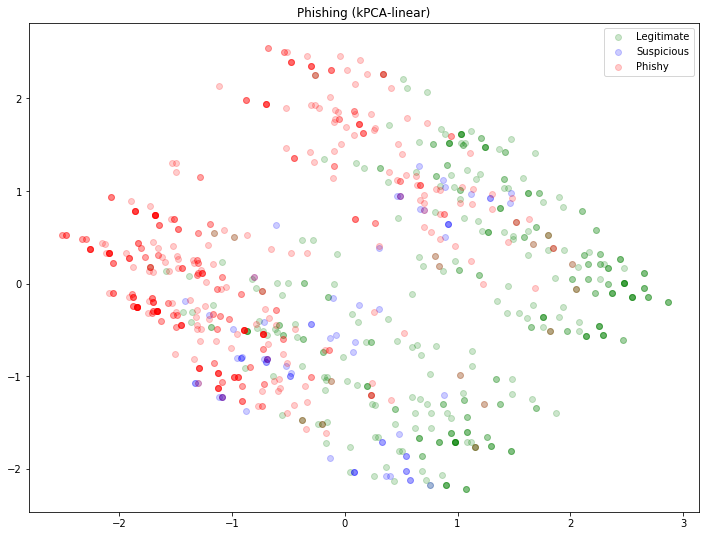

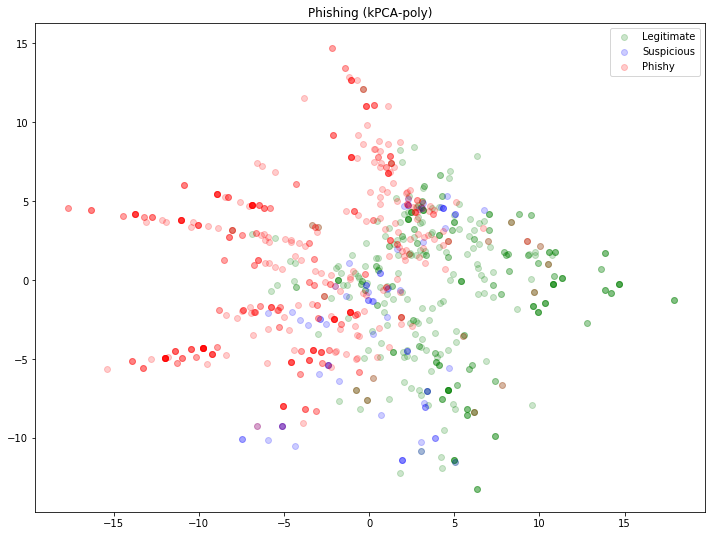

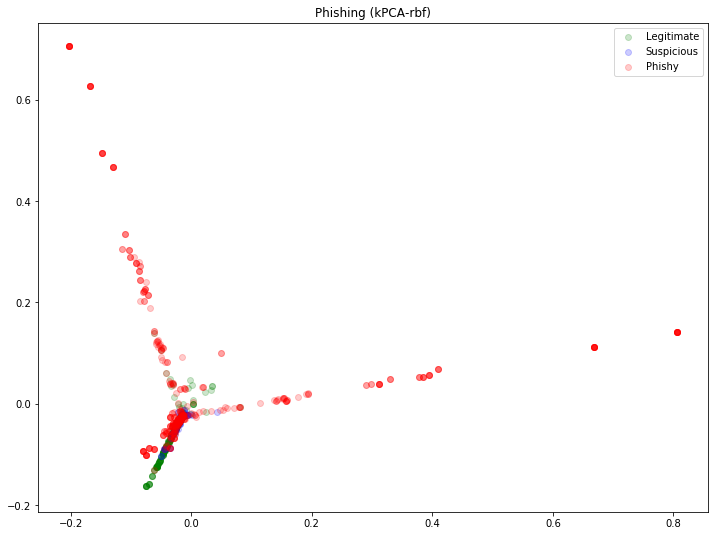

In [ ]:
from sklearn.decomposition import KernelPCA
kpca_tags = ['linear','poly','rbf']
for i in range(len(kpca_tags)):
    kpca = KernelPCA(kernel=kpca_tags[i], gamma=1)

    kpca_fitted = kpca.fit_transform(dt.iloc[:THRESHOLD,:NCOLS-1])
    Xp = pd.DataFrame(kpca_fitted)

    Y = pd.Series(dt.iloc[:THRESHOLD,NCOLS-1], name='Result')
    Y.index = range(THRESHOLD)

    Xp.loc[:,'Result'] = Y

    plt.figure(figsize = (12, 9))

    names = ['Legitimate','Suspicious','Phishy']
    for n, c in zip(names,'gbr'):
        x1 = Xp[Xp['Result'] == n].loc[:,0]
        x2 = Xp[Xp['Result'] == n].loc[:,1]
        plt.scatter(x1, x2, c=c, label=n, alpha=.2)

    plt.title('Phishing (kPCA-'+kpca_tags[i]+')')
    plt.legend()
    plt.show()

---
# Classification methods

In [ ]:
def PClassification(name, clf):
    r = THRESHOLD
    c = dt.shape[1]-1
    train_data = dt.iloc[:r,:c]
    train_answ = dt.iloc[:r,c]
    check_data = dt.iloc[r:,:c]
    check_answ = dt.iloc[r:,c]
    
    clf.fit(train_data, train_answ)
    
    preds = pd.Series(clf.predict(check_data), name='preds')
    reals = pd.Series(check_answ, name='reales')
    reals.index = range(reals.shape[0])
    
    print(name)
    print('acc: {:.2f}%'.format(100*accuracy_score(reals, preds)))
    print()
    print(pd.crosstab(reals, preds))
    print()

## kNN (k=1)

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier
k = 1
PClassification('kNN (k='+str(k)+')', KNeighborsClassifier(k))

kNN (k=1)
acc: 99.64%

preds                                            (empty)   Benign   -  ...  (empty)   Malicious   PartOfAHorizontalPortScan
reales                                                                 ...                                                 
(empty)   Benign   -                                           155259  ...                                              840
(empty)   Malicious   C&C                                           1  ...                                                2
(empty)   Malicious   PartOfAHorizontalPortScan                   364  ...                                           179781

[3 rows x 3 columns]

CPU times: user 37 s, sys: 67.9 ms, total: 37 s
Wall time: 37 s


## Centroids

In [ ]:
%%time
from sklearn.neighbors import NearestCentroid
PClassification('Centroids', NearestCentroid())

Centroids
acc: 41.18%

preds                                            (empty)   Benign   -  ...  (empty)   Malicious   PartOfAHorizontalPortScan
reales                                                                 ...                                                 
(empty)   Benign   -                                            81491  ...                                            11374
(empty)   Malicious   C&C                                           1  ...                                                0
(empty)   Malicious   PartOfAHorizontalPortScan                 44067  ...                                            56982

[3 rows x 3 columns]

CPU times: user 1.65 s, sys: 149 ms, total: 1.8 s
Wall time: 1.68 s


## Gaussian Naïve Bayes

In [ ]:
%%time
from sklearn.naive_bayes import GaussianNB
PClassification('Gaussian Naïve Bayes', GaussianNB())

Gaussian Naïve Bayes
acc: 64.14%

preds                                            (empty)   Benign   -  ...  (empty)   Malicious   PartOfAHorizontalPortScan
reales                                                                 ...                                                 
(empty)   Benign   -                                           152186  ...                                             3859
(empty)   Malicious   C&C                                           0  ...                                                0
(empty)   Malicious   PartOfAHorizontalPortScan                116673  ...                                            63472

[3 rows x 3 columns]

CPU times: user 2.42 s, sys: 36 ms, total: 2.45 s
Wall time: 2.45 s


## LDA

In [ ]:
%%time
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
PClassification('LDA', LinearDiscriminantAnalysis())

LDA
acc: 94.44%

preds                                            (empty)   Benign   -  ...  (empty)   Malicious   PartOfAHorizontalPortScan
reales                                                                 ...                                                 
(empty)   Benign   -                                           138118  ...                                            17984
(empty)   Malicious   C&C                                           0  ...                                                3
(empty)   Malicious   PartOfAHorizontalPortScan                   612  ...                                           179451

[3 rows x 3 columns]

CPU times: user 4.36 s, sys: 200 ms, total: 4.56 s
Wall time: 4.34 s


## Logistic Regression

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression
PClassification('Logistic Regression', LogisticRegression())

Logistic Regression
acc: 89.19%

preds                                            (empty)   Benign   -  (empty)   Malicious   PartOfAHorizontalPortScan
reales                                                                                                                
(empty)   Benign   -                                           132136                                            23966
(empty)   Malicious   C&C                                           0                                                3
(empty)   Malicious   PartOfAHorizontalPortScan                 12372                                           167773

CPU times: user 49.6 s, sys: 16.1 s, total: 1min 5s
Wall time: 45.3 s


## Decision Tree

In [ ]:
%%time
from sklearn.tree import DecisionTreeClassifier
PClassification('Decision Tree', DecisionTreeClassifier())

Decision Tree
acc: 100.00%

preds                                            (empty)   Benign   -  ...  (empty)   Malicious   PartOfAHorizontalPortScan
reales                                                                 ...                                                 
(empty)   Benign   -                                           156099  ...                                                3
(empty)   Malicious   C&C                                           0  ...                                                0
(empty)   Malicious   PartOfAHorizontalPortScan                     0  ...                                           180145

[3 rows x 3 columns]

CPU times: user 3.25 s, sys: 6.55 ms, total: 3.26 s
Wall time: 3.26 s


## Bagging with kNN (k=1)

In [ ]:
%%time
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
k = 1
PClassification('Bagging with kNN (k='+str(k)+')', BaggingClassifier(KNeighborsClassifier(k)))

Bagging with kNN (k=1)
acc: 99.54%

preds                                            (empty)   Benign   -  ...  (empty)   Malicious   PartOfAHorizontalPortScan
reales                                                                 ...                                                 
(empty)   Benign   -                                           155146  ...                                              955
(empty)   Malicious   C&C                                           1  ...                                                2
(empty)   Malicious   PartOfAHorizontalPortScan                   601  ...                                           179544

[3 rows x 3 columns]

CPU times: user 4min 44s, sys: 626 ms, total: 4min 45s
Wall time: 4min 44s


## Random Forest (n_est=10)

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier
PClassification('Random Forest', RandomForestClassifier(n_estimators=10))

Random Forest
acc: 99.99%

preds                                            (empty)   Benign   -  ...  (empty)   Malicious   PartOfAHorizontalPortScan
reales                                                                 ...                                                 
(empty)   Benign   -                                           156078  ...                                               24
(empty)   Malicious   C&C                                           1  ...                                                0
(empty)   Malicious   PartOfAHorizontalPortScan                     6  ...                                           180139

[3 rows x 3 columns]

CPU times: user 10.4 s, sys: 18.8 ms, total: 10.4 s
Wall time: 10.4 s


## Ada Boost

In [ ]:
%%time
from sklearn.ensemble import AdaBoostClassifier
PClassification('Ada Boost', AdaBoostClassifier())

Ada Boost
acc: 79.97%

preds                                            (empty)   Benign   -  (empty)   Malicious   PartOfAHorizontalPortScan
reales                                                                                                                
(empty)   Benign   -                                           148776                                             7326
(empty)   Malicious   C&C                                           3                                                0
(empty)   Malicious   PartOfAHorizontalPortScan                 60012                                           120133

CPU times: user 1min 38s, sys: 158 ms, total: 1min 38s
Wall time: 1min 38s


## Gradient Boosting

In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
PClassification('Gradient Boosting', GradientBoostingClassifier())

Gradient Boosting
acc: 100.00%

preds                                            (empty)   Benign   -  ...  (empty)   Malicious   PartOfAHorizontalPortScan
reales                                                                 ...                                                 
(empty)   Benign   -                                           156099  ...                                                3
(empty)   Malicious   C&C                                           0  ...                                                0
(empty)   Malicious   PartOfAHorizontalPortScan                     0  ...                                           180145

[3 rows x 3 columns]

CPU times: user 3min 33s, sys: 506 ms, total: 3min 34s
Wall time: 3min 34s


## SVC - linear

In [ ]:
%%time
from sklearn.svm import SVC
PClassification('SVC', SVC(kernel='linear'))

## SVC - poly

In [ ]:
%%time
from sklearn.svm import SVC
PClassification('SVC', SVC(kernel='poly'))

## SVC - rbf

In [ ]:
%%time
from sklearn.svm import SVC
PClassification('SVC', SVC(kernel='rbf'))

## MLP

In [ ]:
%%time
from sklearn.neural_network import MLPClassifier
PClassification('Multi-Layer Perceptron', MLPClassifier(hidden_layer_sizes=(5,),max_iter=1000, solver='lbfgs'))

---
# Testing parameters

In [ ]:
def classification(clf):
    r = THRESHOLD
    c = dt.shape[1]-1
    train_data = dt.iloc[:r,:c]
    train_answ = dt.iloc[:r,c]
    check_data = dt.iloc[r:,:c]
    check_answ = dt.iloc[r:,c]
    
    clf.fit(train_data, train_answ)
    
    preds = pd.Series(clf.predict(check_data), name='preds')
    reals = pd.Series(check_answ, name='reales')
    reals.index = range(reals.shape[0])
    
    acc = round(100*accuracy_score(reals, preds),2)
    return acc    

## kNN (k)

In [ ]:
df = pd.DataFrame(columns=['k', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for k in range(1,10+1):
    t1=t.tic()
    v = [classification(KNeighborsClassifier(k)) for j in range(N)]
    t2=t.toc()
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    tm=round(1000*t.elapsed/N,2)
    df.loc[k-1] = [k,tm,r]

In [ ]:
df

,k,time(ms),acc(%)
0,1.0,46.20,85.14
1,2.0,46.59,83.59
2,3.0,47.17,86.70
3,4.0,48.82,86.25
4,5.0,49.48,86.92
5,6.0,49.98,85.37
6,7.0,50.27,86.47
7,8.0,50.91,86.92
8,9.0,51.89,86.47
9,10.0,52.52,85.14


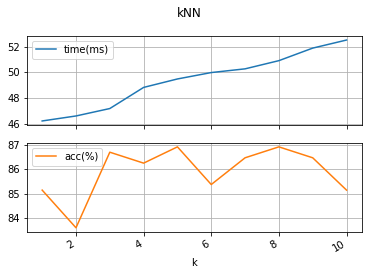

In [ ]:
p=df.plot(0,[1,2], title='kNN',
        legend=True, grid = True,
        subplots=True, sharex=True)

## Centroids (shrink_threshold)

In [ ]:
df = pd.DataFrame(columns=['shrink_threshold', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(NearestCentroid(shrink_threshold=(0.1*i))) for j in range(N)]
    t2=t.toc()
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    tm=round(1000*t.elapsed/N,2)
    df.loc[i-1] = [0.1*i,tm,r]

In [ ]:
df

,shrink_threshold,time(ms),acc(%)
0,0.1,9.03,74.94
1,0.2,8.63,75.17
2,0.3,8.55,75.83
3,0.4,8.62,75.83
4,0.5,8.62,76.27
5,0.6,8.70,76.27
6,0.7,8.71,75.83
7,0.8,8.62,76.50
8,0.9,8.54,76.94
9,1.0,8.50,76.72


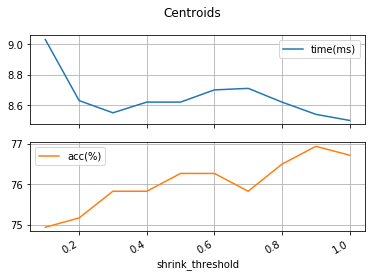

In [ ]:
p=df.plot(0,[1,2], title='Centroids',
        legend=True, grid = True,
        subplots=True, sharex=True)

## Gaussian Naïve Bayes (None)
Has no parameters

## LDA (slover, shrinkage)

In [ ]:
df1 = pd.DataFrame(columns=['shrinkage', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(LinearDiscriminantAnalysis(solver='lsqr',shrinkage=0.1*i)) for j in range(N)]
    t2=t.toc()
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    tm=round(1000*t.elapsed/N,2)
    df1.loc[i-1] = [0.1*i,tm,r]

In [ ]:
df1

,shrinkage,time(ms),acc(%)
0,0.1,13.86,82.93
1,0.2,13.61,83.15
2,0.3,13.53,83.37
3,0.4,13.62,83.59
4,0.5,13.66,83.15
5,0.6,13.66,83.37
6,0.7,12.93,83.59
7,0.8,14.57,82.48
8,0.9,13.67,81.82
9,1.0,13.62,80.71


In [ ]:
df2 = pd.DataFrame(columns=['shrinkage', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(LinearDiscriminantAnalysis(solver='eigen',shrinkage=0.1*i)) for j in range(N)]
    t2=t.toc()
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    tm=round(1000*t.elapsed/N,2)
    df2.loc[i-1] = [0.1*i,tm,r]

In [ ]:
df2

,shrinkage,time(ms),acc(%)
0,0.1,14.16,82.93
1,0.2,14.82,83.15
2,0.3,13.99,83.37
3,0.4,13.85,83.59
4,0.5,14.10,83.15
5,0.6,14.20,83.37
6,0.7,13.94,83.59
7,0.8,14.24,82.48
8,0.9,13.89,81.82
9,1.0,14.32,80.71


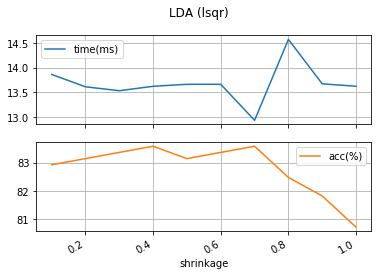

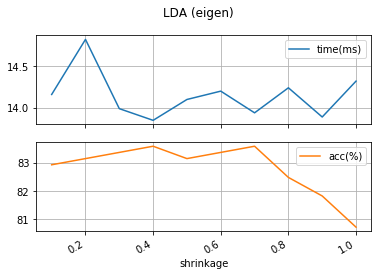

In [ ]:
p=df1.plot(0,[1,2], title='LDA (lsqr)',
        legend=True, grid = True,
        subplots=True, sharex=True)
p=df2.plot(0,[1,2], title='LDA (eigen)',
        legend=True, grid = True,
        subplots=True, sharex=True)

## Logistic Regression (tol)

In [ ]:
df = pd.DataFrame(columns=['tol', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(LogisticRegression(tol=10**(5-i))) for j in range(N)]
    t2=t.toc()
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    tm=round(1000*t.elapsed/N,2)
    df.loc[i-1] = [10**(5-i),tm,r]

In [ ]:
df

,tol,time(ms),acc(%)
0,10000.00000,15.23,38.58
1,1000.00000,15.15,38.58
2,100.00000,15.88,83.37
3,10.00000,19.33,82.71
4,1.00000,24.49,83.15
5,0.10000,27.95,83.15
6,0.01000,33.40,83.15
7,0.00100,34.74,83.15
8,0.00010,34.97,83.15
9,0.00001,35.32,83.15


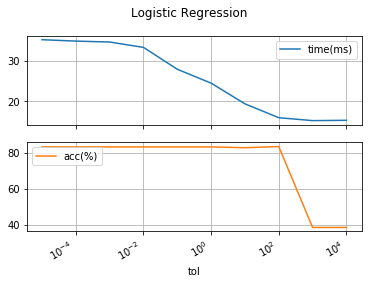

In [ ]:
p=df.plot(0,[1,2], title='Logistic Regression',
        legend=True, grid = True, logx=True,
        subplots=True, sharex=True)

## Decision Tree (max_depth)

In [ ]:
df = pd.DataFrame(columns=['max_depth', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(DecisionTreeClassifier(max_depth=i)) for j in range(N)]
    t2=t.toc()
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    tm=round(1000*t.elapsed/N,2)
    df.loc[i-1] = [i,tm,r]

In [ ]:
df

,max_depth,time(ms),acc(%)
0,1.0,8.38,84.26
1,2.0,8.67,84.26
2,3.0,9.07,83.37
3,4.0,8.98,86.03
4,5.0,9.33,88.47
5,6.0,9.48,89.70
6,7.0,9.47,90.36
7,8.0,9.61,89.40
8,9.0,9.62,88.46
9,10.0,9.71,88.02


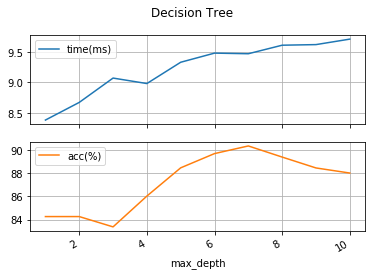

In [ ]:
p=df.plot(0,[1,2], title='Decision Tree',
        legend=True, grid = True,
        subplots=True, sharex=True)

## Bagging with kNN (k=1) (max_samples)

In [ ]:
df = pd.DataFrame(columns=['max_samples', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(BaggingClassifier(KNeighborsClassifier(k),max_samples=10*i)) for j in range(N)]
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    t2=t.toc()
    tm=round(1000*t.elapsed/N,2)
    df.loc[i-1] = [10*i,tm,r]

In [ ]:
df

,max_samples,time(ms),acc(%)
0,10.0,44.22,52.78
1,20.0,45.11,80.65
2,30.0,50.18,82.20
3,40.0,53.47,82.59
4,50.0,57.82,82.85
5,60.0,60.64,82.91
6,70.0,64.69,82.84
7,80.0,67.35,82.72
8,90.0,69.20,82.93
9,100.0,69.55,82.81


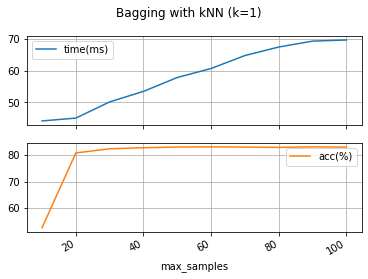

In [ ]:
p=df.plot(0,[1,2], title='Bagging with kNN (k=1)',
        legend=True, grid = True,
        subplots=True, sharex=True)

## Random Forest (max_depth)

In [ ]:
df = pd.DataFrame(columns=['max_depth', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(RandomForestClassifier(n_estimators=10,max_depth=i)) for j in range(N)]
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    t2=t.toc()
    tm=round(1000*t.elapsed/N,2)
    df.loc[i-1] = [i,tm,r]

In [ ]:
df

,max_depth,time(ms),acc(%)
0,1.0,40.85,81.80
1,2.0,40.89,84.46
2,3.0,41.65,84.71
3,4.0,42.73,85.04
4,5.0,43.05,85.64
5,6.0,44.87,86.94
6,7.0,44.92,88.00
7,8.0,45.74,88.28
8,9.0,46.24,88.02
9,10.0,46.23,87.99


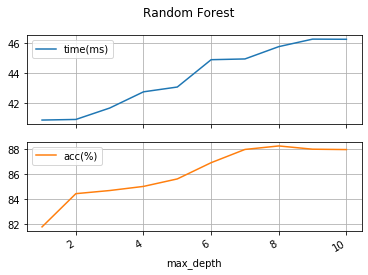

In [ ]:
p=df.plot(0,[1,2], title='Random Forest',
        legend=True, grid = True,
        subplots=True, sharex=True)

## Ada Boost (n_estimators)

In [ ]:
df = pd.DataFrame(columns=['n_estimators', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(AdaBoostClassifier(n_estimators=i)) for j in range(N)]
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    t2=t.toc()
    tm=round(1000*t.elapsed/N,2)
    df.loc[i-1] = [i,tm,r]

In [ ]:
df

,n_estimators,time(ms),acc(%)
0,1.0,12.04,84.26
1,2.0,17.37,84.26
2,3.0,22.38,83.37
3,4.0,27.73,81.15
4,5.0,32.86,83.37
5,6.0,37.91,83.15
6,7.0,43.96,82.93
7,8.0,49.03,83.15
8,9.0,53.72,83.15
9,10.0,58.90,83.81


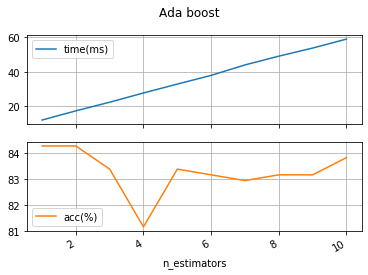

In [ ]:
p=df.plot(0,[1,2], title='Ada boost',
        legend=True, grid = True,
        subplots=True, sharex=True)

## Gradient Boosting (n_estimators)

In [ ]:
df = pd.DataFrame(columns=['n_estimators', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(GradientBoostingClassifier(n_estimators=i)) for j in range(N)]
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    t2=t.toc()
    tm=round(1000*t.elapsed/N,2)
    df.loc[i-1] = [i,tm,r]

In [ ]:
df

,n_estimators,time(ms),acc(%)
0,1.0,17.58,75.61
1,2.0,24.88,84.26
2,3.0,32.73,85.59
3,4.0,40.49,85.59
4,5.0,49.61,85.14
5,6.0,56.05,84.48
6,7.0,65.26,85.14
7,8.0,71.26,85.37
8,9.0,79.65,86.25
9,10.0,90.39,85.59


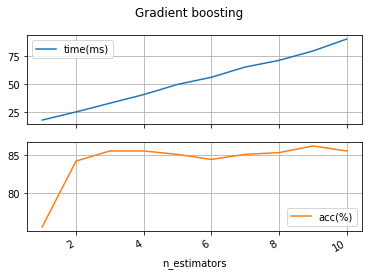

In [ ]:
p=df.plot(0,[1,2], title='Gradient boosting',
        legend=True, grid = True,
        subplots=True, sharex=True)

## SVC - linear (tol)

In [ ]:
df = pd.DataFrame(columns=['tol', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(SVC(kernel='linear',tol=10**(5-i))) for j in range(N)]
    t2=t.toc()
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    tm=round(1000*t.elapsed/N,2)
    df.loc[i-1] = [10**(5-i),tm,r]

In [ ]:
df

,tol,time(ms),acc(%)
0,10000.00000,8.80,6.87
1,1000.00000,8.97,6.87
2,100.00000,8.83,6.87
3,10.00000,8.84,6.87
4,1.00000,26.73,85.14
5,0.10000,30.95,84.48
6,0.01000,33.66,84.26
7,0.00100,34.98,84.26
8,0.00010,35.42,84.26
9,0.00001,35.77,84.26


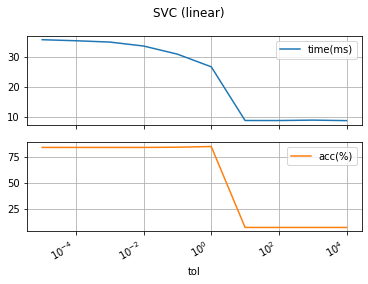

In [ ]:
p=df.plot(0,[1,2], title='SVC (linear)',
        legend=True, grid = True, logx=True,
        subplots=True, sharex=True)

## SVC - poly (tol)

In [ ]:
df = pd.DataFrame(columns=['tol', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(SVC(kernel='poly',tol=10**(5-i))) for j in range(N)]
    t2=t.toc()
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    tm=round(1000*t.elapsed/N,2)
    df.loc[i-1] = [10**(5-i),tm,r]

In [ ]:
df

,tol,time(ms),acc(%)
0,10000.00000,8.83,6.87
1,1000.00000,9.21,6.87
2,100.00000,8.91,6.87
3,10.00000,8.73,6.87
4,1.00000,25.16,86.92
5,0.10000,29.82,87.58
6,0.01000,34.88,87.58
7,0.00100,36.65,87.58
8,0.00010,39.65,87.58
9,0.00001,41.07,87.58


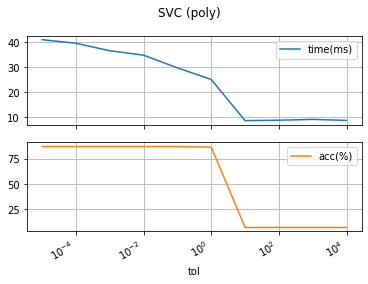

In [ ]:
p=df.plot(0,[1,2], title='SVC (poly)',
        legend=True, grid = True, logx=True,
        subplots=True, sharex=True)

## SVC - rbf (tol)

In [ ]:
df = pd.DataFrame(columns=['tol', 'time(ms)', 'acc(%)'])
t = TicToc()
N = 100

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(SVC(kernel='rbf',tol=10**(5-i))) for j in range(N)]
    t2=t.toc()
    r = round(np.mean(sorted(v)[N//20:-(N//20)]),2)
    tm=round(1000*t.elapsed/N,2)
    df.loc[i-1] = [10**(5-i),tm,r]

In [ ]:
df

,tol,time(ms),acc(%)
0,10000.00000,9.01,6.87
1,1000.00000,9.16,6.87
2,100.00000,9.15,6.87
3,10.00000,8.88,6.87
4,1.00000,34.12,87.80
5,0.10000,40.27,87.80
6,0.01000,43.49,87.58
7,0.00100,44.79,87.80
8,0.00010,46.56,87.80
9,0.00001,48.89,87.80


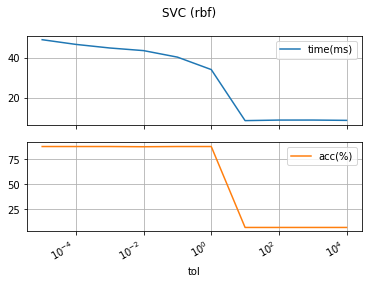

In [ ]:
p=df.plot(0,[1,2], title='SVC (rbf)',
        legend=True, grid = True, logx=True,
        subplots=True, sharex=True)

## MLP (hidden_layer_sizes)

In [ ]:
df = pd.DataFrame(columns=['hidden_layer_sizes', 'time(s)', 'acc(%)'])
t = TicToc()
N = 10

for i in range(1,10+1):
    t1=t.tic()
    v = [classification(MLPClassifier(hidden_layer_sizes=(5*i,),max_iter=1e4, solver='lbfgs')) for j in range(N)]
    r = round(np.mean(sorted(v)[2:-2]),2)
    t2=t.toc()
    tm=round(t.elapsed/N,2)
    df.loc[i-1] = [5*i,tm,r]

In [ ]:
df

,hidden_layer_sizes,time(s),acc(%)
0,5.0,0.64,85.25
1,10.0,3.31,86.47
2,15.0,3.56,86.03
3,20.0,2.17,85.40
4,25.0,1.72,86.10
5,30.0,1.58,86.25
6,35.0,1.65,86.44
7,40.0,1.50,85.70
8,45.0,1.44,87.18
9,50.0,1.55,86.62


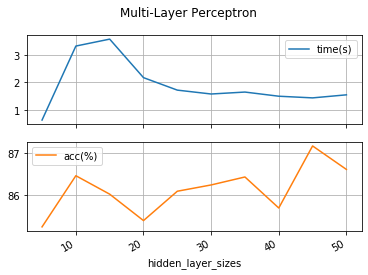

In [ ]:
p=df.plot(0,[1,2], title='Multi-Layer Perceptron',
        legend=True, grid = True,
        subplots=True, sharex=True)